In [11]:
%matplotlib inline

In [12]:
import sys
sys.path.append('../../../non_corrupt_starclass/starclass')
#sys.path.append('../../../shap/')

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sqlite3
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import shap
shap.initjs()

[<matplotlib.lines.Line2D at 0x2aec739a2320>]

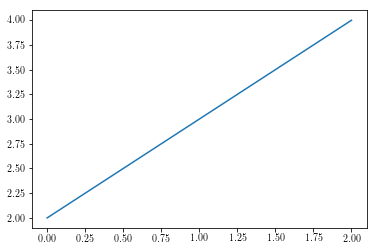

In [14]:
plt.plot([0, 1, 2], [2, 3, 4])

In [15]:
connection = sqlite3.connect('../starclass/training_sets/data/keplerq9/todo.sqlite')

In [16]:
df = pd.read_sql_query("select * from starclass;", connection)
labels = pd.read_sql_query("select * from diagnostics;", connection)
labels['label'] = [i.split('/')[0] for i in labels['lightcurve'].values]
print(labels.head(10))
print(df.head(10))
connection.close()

   priority     starid               lightcurve  elaptime     mean_flux  \
0         1  201131882  APERIODIC/201131882.txt  3.716774  5.551115e-11   
1         2  201132839  APERIODIC/201132839.txt  3.811152 -5.551115e-11   
2         3  201133037  APERIODIC/201133037.txt  3.913442 -5.551115e-11   
3         4  201141142  APERIODIC/201141142.txt  3.819385 -5.551115e-11   
4         5  201142064  APERIODIC/201142064.txt  3.274527  0.000000e+00   
5         6  201142448  APERIODIC/201142448.txt  3.521514 -5.551115e-11   
6         7  201147037  APERIODIC/201147037.txt  3.156519  0.000000e+00   
7         8  201150637  APERIODIC/201150637.txt  3.213272  0.000000e+00   
8         9  201153558  APERIODIC/201153558.txt  3.205033 -5.551115e-11   
9        10  201154950  APERIODIC/201154950.txt  3.186235  5.551115e-11   

       variance  variability  mask_size  pos_row  pos_column  contamination  \
0  1.309640e+06   892.888975        350      0.0         0.0            0.0   
1  1.152794e+06 

In [17]:
y = labels['label'].values[df['priority'].unique()-1].astype('U15')
priority = labels['priority'].values[df['priority'].unique()-1]
y[y == 'APERIODIC'] = 'aperiodic'
y[y == 'CONSTANT'] = 'constant'
y[y == 'RRLYR_CEPHEID'] = 'RRLyr/Ceph'
y[y == 'CONTACT_ROT'] = 'contactEB/spots'
y[y == 'DSCT_BCEP'] = 'dSct/bCep'
y[y == 'ECLIPSE'] = 'transit/eclipse'
y[y == 'GDOR_SPB'] = 'gDor/spB'
y[y == 'SOLARLIKE'] = 'solar'

In [18]:
rfgc = df.loc[(df['classifier'] == 'rfgc'), ]#.values.reshape(len(df)//32, 8)
#slosh = df.loc[(df['classifier'] == 'slosh'), 'prob'].values.reshape(len(df)//32, 8)
#xgb = df.loc[(df['classifier'] == 'xgb'), 'prob'].values.reshape(len(df)//32, 8)

In [34]:
feature_names = [r'$f_{1}$', r'$f_{2}$', r'$f_{3}$', r'$f_{4}$', r'$f_{5}$', r'$f_{6}$', r'$A_{21}$', r'$A_{31}$', r'$\phi_{21}$', r'$\phi_{31}$', 
                 'SOM location 1', 'SOM location 2', r'$\phi$ p2p98', r'$\phi$ p2p mean', 'p2p98', 'p2p mean', r'$\psi^{2}$', 'Zero-crossings', r'$F_{p}07$', r'$F_{p}7$', r'$F_{p}20$', r'$F_{p}50$']
class_names = ['RR Lyr/Cepheid', 'Aperiodic', 'Constant', 
                      'Contact binaries/rotation', r'$\delta$ Sct/$\beta$ Cep', '$\gamma$ Dor/SPB', 
                      'Solar-like', 'Eclipsing/Transiting']

In [20]:
with open('../starclass/data/L1/keplerq9/meta_fold01/rfgc_classifier_v01.pickle', 'rb') as pickle_file:
    model = pickle.load(pickle_file)
    
#model = pickle.load('../starclass/data/L1/keplerq9/meta_fold01/rfgc_classifier_v01.pickle')

Using TensorFlow backend.


-------------------------------
* WARNING: No pyFFTW detected *
-------------------------------


In [21]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in skf.split(priority, y):
    X_train = np.zeros([len(train_index), 22])
    X_test = np.zeros([len(test_index), 22])
    y_train = y[train_index]
    y_test = y[test_index]
    print(test_index)
    train = priority[train_index]
    for idx, i in enumerate(train):
        X_train[idx,:] = np.loadtxt('../starclass/training_sets/data/keplerq9/features_cache_corr/rfgc_features/'+str(i)+'.txt')
    test = priority[test_index]
    for idx, i in enumerate(test):
        X_test[idx,:] = np.loadtxt('../starclass/training_sets/data/keplerq9/features_cache_corr/rfgc_features/'+str(i)+'.txt')
    break

[  10   27   37 ... 5744 5745 5750]


In [22]:
print(*zip(feature_names, model.feature_importances_))

('freq1', 0.09830404494831756) ('freq2', 0.04911289881073633) ('freq3', 0.0789127259494249) ('freq4', 0.05211929984265933) ('freq5', 0.05287993621002065) ('freq6', 0.08682729959867334) ('freqamp1', 0.017115712820341376) ('freqamp2', 0.019108984590276493) ('phasediff1', 0.02181050143968431) ('phasediff2', 0.02587153130679648) ('somloc1', 0.004750277654742303) ('somloc2', 0.05045198323645449) ('phase1', 0.02411476979472758) ('phase2', 0.014175410842562103) ('p2p1', 0.040310710267025616) ('p2p2', 0.040892411044004456) ('psi', 0.0715521607151531) ('zc', 0.07525855712533552) ('fliper07', 0.056405891376721536) ('fliper7', 0.049838234890872864) ('fliper20', 0.03042509109185909) ('fliper50', 0.03976156644361055)


In [23]:
preds = model.predict(X_test)

In [24]:
accuracy_score(preds, y_test)

0.9913344887348353

In [25]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

starclass


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


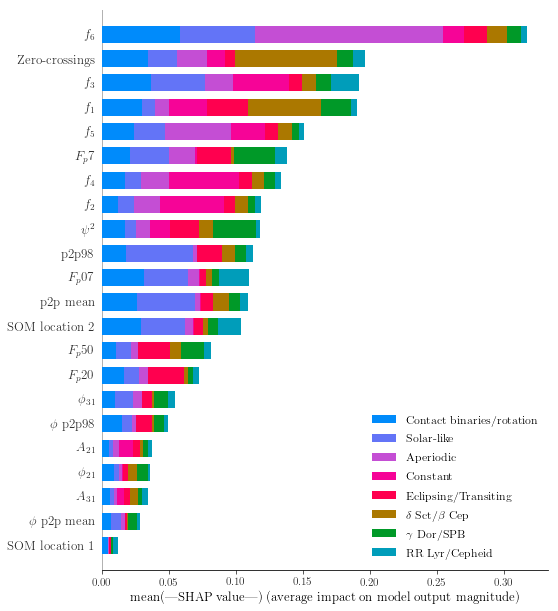

In [42]:
fig = shap.summary_plot(shap_values, X_test, 
                  feature_names=feature_names,
                  class_names=class_names, max_display=len(feature_names))
plt.savefig('RFGC_feature_importance.pdf', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: 

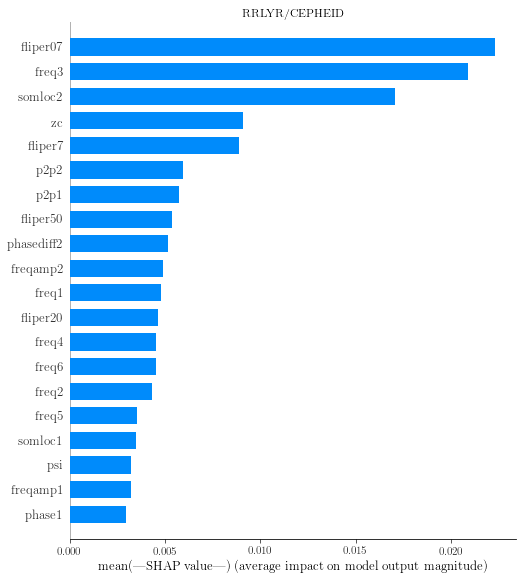

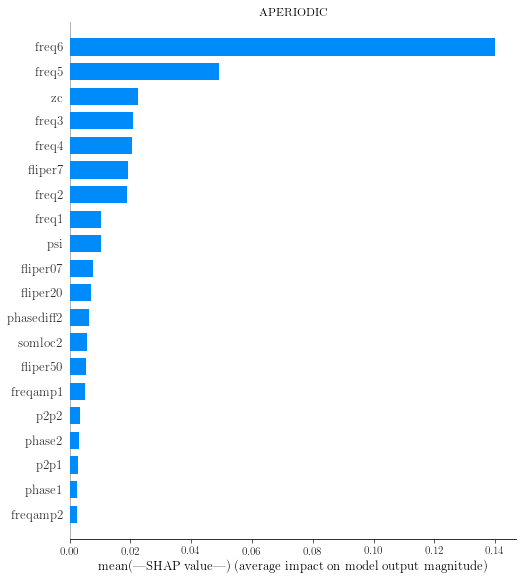

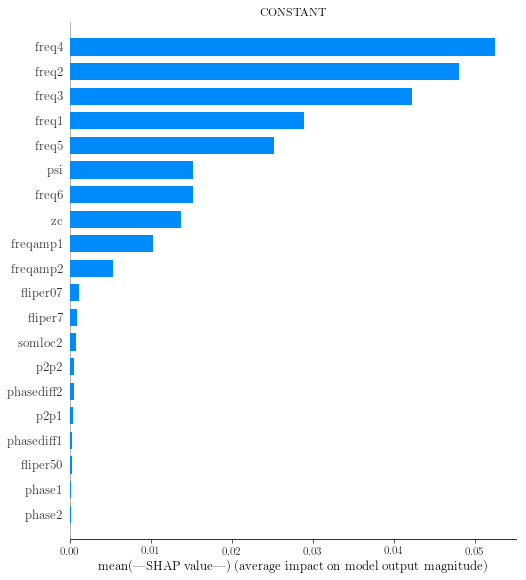

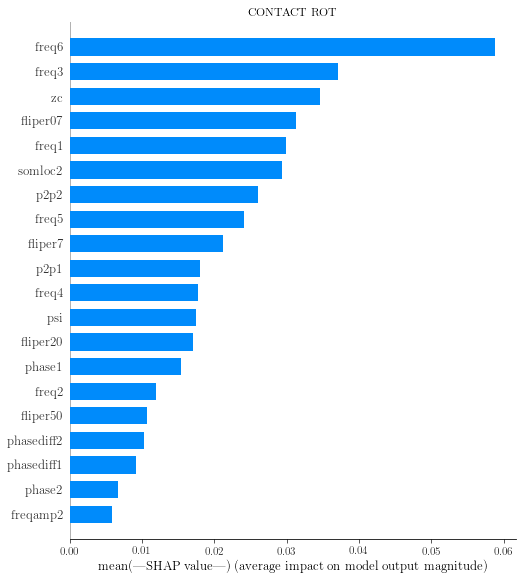

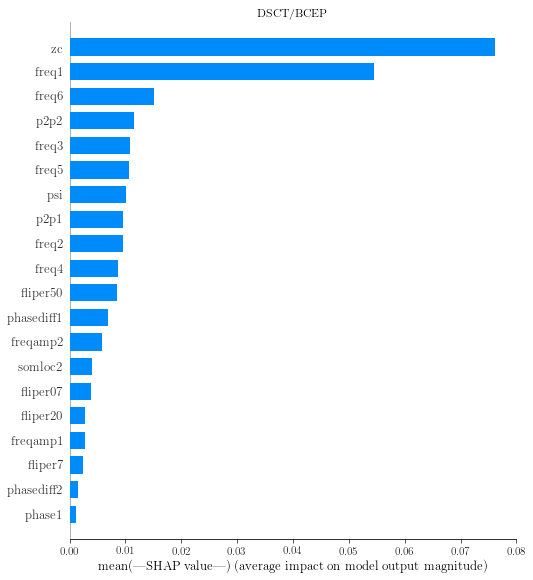

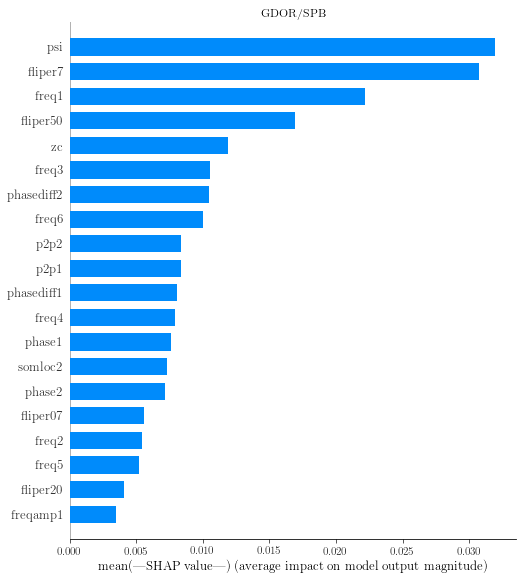

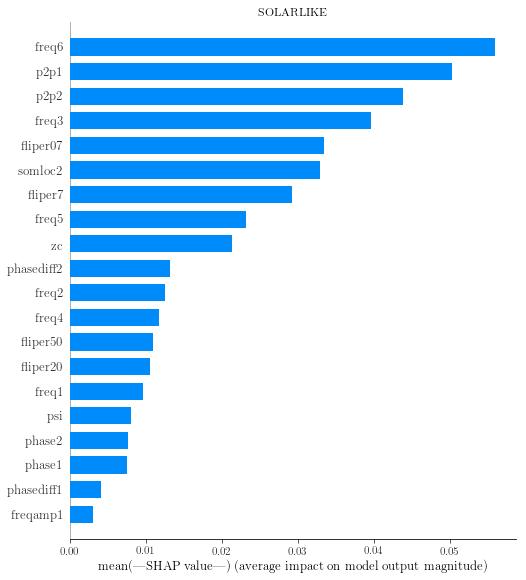

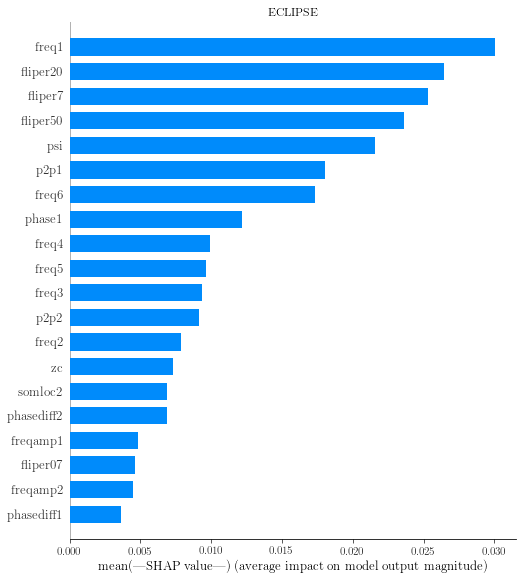

In [27]:
for i in range(len(class_names)):
    plt.figure(i)
    plt.title(class_names[i])
    shap.summary_plot(shap_values[i], X_test, 
                      feature_names=feature_names,
                      class_names=class_names[i], plot_type="bar")
    #plt.savefig(class_names[i]+'.png', bbox_inches='tight')
    plt.show()